# **3 - Preprocessing**

## Imports

In [86]:
import mediapipe as mp
import pandas as pd
import cv2
import json
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

## Predefined variables

In [87]:
CSV_SAVE_PATH = "../saved/"
NPZ_SAVE_PATH = "../saved/"

## Mapping between IDs and labels in dataset

In [88]:
dataset_dir_train = '../data/American Sign Language Letters.v1-v1.coco/train'
dataset_dir_test = '../data/American Sign Language Letters.v1-v1.coco/test'
dataset_dir_val = '../data/American Sign Language Letters.v1-v1.coco/valid'

json_path = os.path.join(dataset_dir_train, '_annotations.coco.json')

In [89]:
with open(json_path, 'r') as f:
    coco = json.load(f)

In [90]:
id_to_filename = {image['id']: image['file_name'] for image in coco['images']}
id_to_label = {category['id']: category['name'] for category in coco['categories']}

In [91]:
image_to_label = {}
for annotation in coco['annotations']:
    image_id = annotation['image_id']
    category_id = annotation['category_id']
    if image_id in id_to_filename:
        image_to_label[image_id] = id_to_label[category_id]

## Landmarks with MediaPipe

In [92]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)
mp_drawing = mp.solutions.drawing_utils

In [93]:
def process_folder(folder_path, dataset_type):
    data = []
    json_path = os.path.join(folder_path, '_annotations.coco.json')
    
    with open(json_path, 'r') as f:
        coco = json.load(f)
    
    # Create mappings for this folder
    id_to_filename = {image['id']: image['file_name'] for image in coco['images']}
    id_to_label = {category['id']: category['name'] for category in coco['categories']}
    
    image_to_label = {}
    for annotation in coco['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        if image_id in id_to_filename:
            image_to_label[image_id] = id_to_label[category_id]
    
    print(f"Processing {dataset_type} folder: {len(image_to_label)} images")
    
    for image_id, label in tqdm(image_to_label.items(), desc=f"Processing {dataset_type}"):
        filename = id_to_filename[image_id]
        image_path = os.path.join(folder_path, filename)

        image = cv2.imread(image_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        result = hands.process(image_rgb)
        if not result.multi_hand_landmarks:
            continue

        landmarks = result.multi_hand_landmarks[0]
        row = []

        for lm in landmarks.landmark:
            row.extend([lm.x, lm.y, lm.z])
            
        row.append(label)
        data.append(row)
    
    return data

# Process all three folders
train_data = process_folder(dataset_dir_train, "train")
test_data = process_folder(dataset_dir_test, "test") 
valid_data = process_folder(dataset_dir_val, "validation")

hands.close()

Processing train folder: 1512 images


Processing train:   0%|          | 0/1512 [00:00<?, ?it/s]

Processing train: 100%|██████████| 1512/1512 [00:53<00:00, 28.51it/s]


Processing test folder: 72 images


Processing test: 100%|██████████| 72/72 [00:02<00:00, 27.67it/s]


Processing validation folder: 144 images


Processing validation: 100%|██████████| 144/144 [00:05<00:00, 26.59it/s]


## Create separate datasets and save to CSV

### Some print statements to check before we start

In [94]:
print("Checking raw data structure:")
print(f"Train data sample length: {len(train_data[0]) if train_data else 0}")
print(f"Test data sample length: {len(test_data[0]) if test_data else 0}")
print(f"Validation data sample length: {len(valid_data[0]) if valid_data else 0}")

print("\n" + "-"*40 + "\n")

if train_data:
    sample = train_data[0]
    print(f"Sample train data structure:")
    print(f"First 5 values: {sample[:5]}")
    print(f"Last 5 values: {sample[-5:]}")
    print(f"Should be: 63 landmarks + 1 label = 64 total, got {len(sample)}")

print("\n" + "-"*40 + "\n")

if test_data:
    sample = test_data[0]
    print(f"Sample test data structure:")
    print(f"First 5 values: {sample[:5]}")
    print(f"Last 5 values: {sample[-5:]}")
    print(f"Should be: 63 landmarks + 1 label = 64 total, got {len(sample)}")

print("\n" + "-"*40 + "\n")

if valid_data:
    sample = valid_data[0]
    print(f"Sample validation data structure:")
    print(f"First 5 values: {sample[:5]}")
    print(f"Last 5 values: {sample[-5:]}")
    print(f"Should be: 63 landmarks + 1 label = 64 total, got {len(sample)}")

Checking raw data structure:
Train data sample length: 64
Test data sample length: 64
Validation data sample length: 64

----------------------------------------

Sample train data structure:
First 5 values: [0.4179784655570984, 0.936383843421936, 1.6635594874969684e-06, 0.34161561727523804, 0.9230197072029114]
Last 5 values: [-0.44095855951309204, 0.6528101563453674, 0.8705712556838989, -0.4494030475616455, 'U']
Should be: 63 landmarks + 1 label = 64 total, got 64

----------------------------------------

Sample test data structure:
First 5 values: [0.8338124752044678, 0.6320958137512207, 2.2795359200245002e-07, 0.8202306032180786, 0.5194770693778992]
Last 5 values: [-0.0723734125494957, 0.5590866804122925, 0.689557671546936, -0.046369072049856186, 'G']
Should be: 63 landmarks + 1 label = 64 total, got 64

----------------------------------------

Sample validation data structure:
First 5 values: [0.513287365436554, 0.954075813293457, 4.4877177174384997e-07, 0.6415529847145081, 0.853

### First fix the data structure

In [95]:
def fix_data_structure(data):
    fixed_data = []
    for row in data:
        if len(row) == 64:  # 63 features + 1 label
            fixed_data.append(row)
        else:
            print(f"Warning: Unexpected row length {len(row)}, skipping...")
    return fixed_data

In [96]:
print("Fixing data structure...")
train_data_fixed = fix_data_structure(train_data)
test_data_fixed = fix_data_structure(test_data)
valid_data_fixed = fix_data_structure(valid_data)

print(f"Fixed train data: {len(train_data_fixed)} samples")
print(f"Fixed test data: {len(test_data_fixed)} samples")
print(f"Fixed valid data: {len(valid_data_fixed)} samples")


# Check first fixed sample
if train_data_fixed:
    sample = train_data_fixed[0]
    print(f"\nFixed sample structure:")
    print(f"Length: {len(sample)}")
    print(f"Last value (label): {sample[-1]}")

Fixing data structure...
Fixed train data: 1205 samples
Fixed test data: 61 samples
Fixed valid data: 133 samples

Fixed sample structure:
Length: 64
Last value (label): U


### Create dataframes for each split

In [97]:
train_df = pd.DataFrame(train_data_fixed)
test_df = pd.DataFrame(test_data_fixed)
valid_df = pd.DataFrame(valid_data_fixed)

### Save and combine the dataframes to one CSV-file

In [98]:
train_df.to_csv(f'{CSV_SAVE_PATH}sign_language_train.csv', index=False)
test_df.to_csv(f'{CSV_SAVE_PATH}sign_language_test.csv', index=False)
valid_df.to_csv(f'{CSV_SAVE_PATH}sign_language_valid.csv', index=False)

print(f"\nSaved training data: {len(train_df)} samples")
print(f"Saved test data: {len(test_df)} samples") 
print(f"Saved validation data: {len(valid_df)} samples")


all_data_fixed = train_data_fixed + test_data_fixed + valid_data_fixed
df = pd.DataFrame(all_data_fixed)
df.to_csv(f'{CSV_SAVE_PATH}sign_language_data.csv', index=False)
print(f"Saved combined data: {len(df)} samples to {CSV_SAVE_PATH}sign_language_data.csv")


Saved training data: 1205 samples
Saved test data: 61 samples
Saved validation data: 133 samples
Saved combined data: 1399 samples to ../saved/sign_language_data.csv
Saved combined data: 1399 samples to ../saved/sign_language_data.csv


### Load and check the data inside the CSV's

In [99]:
train_df = pd.read_csv(f'{CSV_SAVE_PATH}sign_language_train.csv')
test_df = pd.read_csv(f'{CSV_SAVE_PATH}sign_language_test.csv') 
valid_df = pd.read_csv(f'{CSV_SAVE_PATH}sign_language_valid.csv')

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Validation set shape:", valid_df.shape)


print(f"\nData structure verification:")
print(f"Training DF columns: {len(train_df.columns)} (should be 64: 63 features + 1 label)")
print(f"Features in training: {train_df.shape[1] - 1}")
print(f"Column names sample: {list(train_df.columns)[:5]} ... {list(train_df.columns)[-5:]}")

Training set shape: (1205, 64)
Test set shape: (61, 64)
Validation set shape: (133, 64)

Data structure verification:
Training DF columns: 64 (should be 64: 63 features + 1 label)
Features in training: 63
Column names sample: ['0', '1', '2', '3', '4'] ... ['59', '60', '61', '62', '63']


### Check label distribution in training set, test set and validation set

In [100]:
print("Label distribution in training set:")
print(train_df.iloc[:, -1].value_counts().sort_index())

print("\nLabel distribution in test set:")
print(test_df.iloc[:, -1].value_counts().sort_index())

print("\nLabel distribution in validation set:")
print(valid_df.iloc[:, -1].value_counts().sort_index())

Label distribution in training set:
63
A    63
B    35
C    30
D    39
E    45
F    49
G    46
H    33
I    65
J    65
K    45
L    61
M    42
N    50
O    43
P    36
Q    42
R    39
S    56
T    38
U    40
V    41
W    45
X    54
Y    41
Z    62
Name: count, dtype: int64

Label distribution in test set:
63
A    1
B    3
C    3
D    1
F    2
G    3
H    2
I    2
J    4
K    3
M    2
N    1
O    3
P    1
Q    2
R    2
S    3
T    5
U    2
V    4
W    2
X    4
Y    2
Z    4
Name: count, dtype: int64

Label distribution in validation set:
63
A    5
B    8
C    2
D    5
E    4
F    7
G    5
H    9
I    2
J    8
K    6
L    4
M    7
N    2
O    4
P    6
Q    4
R    7
S    4
T    6
U    7
V    5
W    3
X    1
Y    8
Z    4
Name: count, dtype: int64


## Preprocessing all datasets

### Define the ``center_hand`` function, given the landmarks

In [101]:
def center_hand(landmarks):
    wrist = landmarks[0]
    centered = landmarks - wrist
    
    return centered

### Define the ``scale_hand`` function, given the landmarks

In [102]:
def scale_hand(landmarks):
    wrist = landmarks[0]
    middle_finger_tip = landmarks[12]
    scale = np.linalg.norm(middle_finger_tip - wrist)

    if scale > 0:
        scaled = landmarks / scale
    else:
        scaled = landmarks

    return scaled

### Define the ``preprocess_dataset`` function, given the dataframe

In [103]:
def preprocess_dataset(df):
    X = df.iloc[:, :-1].values  # all numeric columns (excluding last label column)
    y = df.iloc[:, -1].values   # labels (last column)
    
    print(f"Original data shape: {X.shape}")
    print(f"Features: {X.shape[1]} (should be 63 = 21 landmarks * 3 coordinates)")
    print(f"Labels: {len(y)}")
    
    if X.shape[1] != 63:
        raise ValueError(f"Expected 63 features (21 landmarks * 3 coordinates), but got {X.shape[1]}.")
    
    X_reshaped = X.reshape(-1, 21, 3) # (num_samples, 21 landmarks, 3 coordinates)
    X_centered = np.array([center_hand(hand) for hand in X_reshaped]) # center hand landmarks
    X_scaled = np.array([scale_hand(hand) for hand in X_centered]) # scale hand landmarks

    X_processed = X_scaled.reshape(-1, 63) # (num_samples, 63 features)
    
    return X_processed, y

### Checking the datastructure first

In [104]:
print("Debugging data structure:")
print(f"Training DataFrame shape: {train_df.shape}")
print(f"Number of columns: {len(train_df.columns)}")
print(f"Column names: {list(train_df.columns)}")

print(f"\nFirst row sample:")
print(f"First 5 values: {train_df.iloc[0, :5].values}")
print(f"Last 5 values: {train_df.iloc[0, -5:].values}")

Debugging data structure:
Training DataFrame shape: (1205, 64)
Number of columns: 64
Column names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63']

First row sample:
First 5 values: [np.float64(0.4179784655570984) np.float64(0.936383843421936)
 np.float64(1.6635594874969684e-06) np.float64(0.341615617275238)
 np.float64(0.9230197072029114)]
Last 5 values: [np.float64(-0.440958559513092) np.float64(0.6528101563453674)
 np.float64(0.8705712556838989) np.float64(-0.4494030475616455) 'U']


### Preprocessing the datasets

In [105]:
print("Processing training dataset...")
X_train_processed, y_train = preprocess_dataset(train_df)

print("\nProcessing test dataset...")
X_test_processed, y_test = preprocess_dataset(test_df)  

print("\nProcessing validation dataset...")
X_valid_processed, y_valid = preprocess_dataset(valid_df)

print("\nProcessed training data shape:", X_train_processed.shape, len(y_train))
print("Processed test data shape:", X_test_processed.shape, len(y_test))
print("Processed validation data shape:", X_valid_processed.shape, len(y_valid))

Processing training dataset...
Original data shape: (1205, 63)
Features: 63 (should be 63 = 21 landmarks * 3 coordinates)
Labels: 1205

Processing test dataset...
Original data shape: (61, 63)
Features: 63 (should be 63 = 21 landmarks * 3 coordinates)
Labels: 61

Processing validation dataset...
Original data shape: (133, 63)
Features: 63 (should be 63 = 21 landmarks * 3 coordinates)
Labels: 133

Processed training data shape: (1205, 63) 1205
Processed test data shape: (61, 63) 61
Processed validation data shape: (133, 63) 133


### Scale all datasets

In [106]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
X_test_scaled = scaler.transform(X_test_processed)
X_valid_scaled = scaler.transform(X_valid_processed)

print("Final scaled data shapes:")
print("Training:", X_train_scaled.shape)
print("Test:", X_test_scaled.shape) 
print("Validation:", X_valid_scaled.shape)

Final scaled data shapes:
Training: (1205, 63)
Test: (61, 63)
Validation: (133, 63)


## Save all the data and the scaler in a NumPy ``.npz`` file

In [107]:
np.savez(f"{NPZ_SAVE_PATH}sign_language_preprocessed.npz", 
         X_train=X_train_scaled, 
         X_test=X_test_scaled, 
         X_valid=X_valid_scaled,
         y_train=y_train, 
         y_test=y_test, 
         y_valid=y_valid,
         scaler=scaler)

print("Saved preprocessed data with correct train/test/validation splits!")
print(f"Training: {len(y_train)} samples")
print(f"Test: {len(y_test)} samples") 
print(f"Validation: {len(y_valid)} samples")

Saved preprocessed data with correct train/test/validation splits!
Training: 1205 samples
Test: 61 samples
Validation: 133 samples


## Define ``plot_hand`` function, given the landmarks

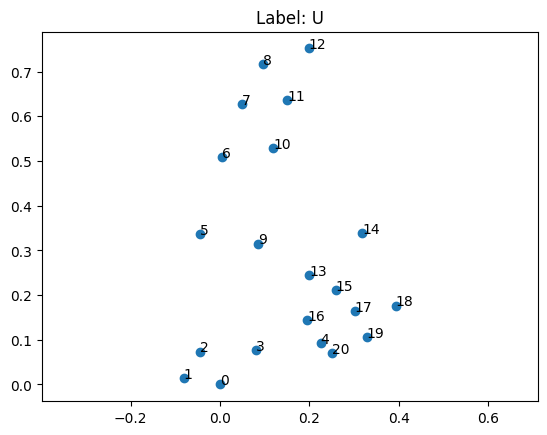

In [108]:
def plot_hand(landmarks, label=None):
    plt.figure()
    plt.scatter(landmarks[:,0], -landmarks[:,1])
    for i, (x,y,_) in enumerate(landmarks):
        plt.text(x, -y, str(i))
    plt.title(f"Label: {label}")
    plt.axis("equal")
    plt.show()


sample_idx = 0
if len(X_train_processed) > sample_idx:
    sample_landmarks = X_train_processed[sample_idx].reshape(21, 3)
    plot_hand(sample_landmarks, y_train[sample_idx])